<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/SkimLit-Chrome-Extension/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Skimlit
The propose of this project is to built an NLP model to make reading medical abstract easier.

The paper we are replicating (the source of dataset that we'll be using) is available here: https://arxiv.org/pdf/1710.06071


In [1]:
!nvidia-smi -L


/bin/bash: line 1: nvidia-smi: command not found


## Get the data
PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os
filename=[data_dir+filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [5]:
# Preprocess data
def get_lines(filename):
  with open(filename) as file:
    return file.readlines()

In [6]:
train_lines=get_lines(filename[0])
train_lines[:30]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [7]:
def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename)
  abstract_line=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith('###'):
      abstract_id=line
      abstract_line=""

    elif line.isspace():
      abstract_line_split=abstract_line.splitlines()
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_line+=line
  return abstract_samples

In [8]:
train_samples=preprocess_text_with_line_numbers(filename[2])
test_samples=preprocess_text_with_line_numbers(filename[1])
validation_sample=preprocess_text_with_line_numbers(filename[0])

len(train_samples),len(test_samples),len(validation_sample)

(30212, 180040, 30135)

In [9]:
train_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

In [10]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(validation_sample)
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


# Distribution of labels in the training data


In [11]:
train_df.target.value_counts()

,count
target,
METHODS,9964
RESULTS,9841
CONCLUSIONS,4582
BACKGROUND,3449
OBJECTIVE,2376


It seems like the abstract talks mostly about Methods and Results and less about Objective

<Axes: ylabel='Frequency'>

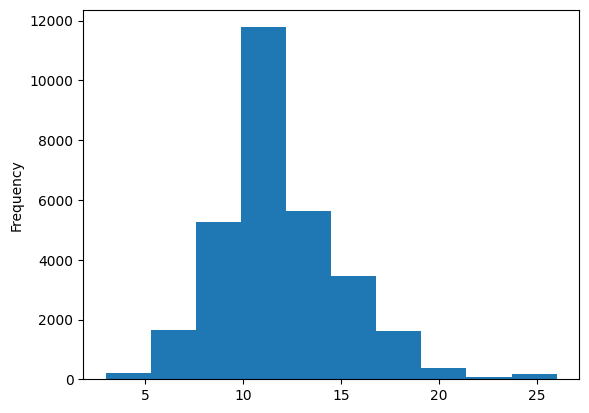

In [12]:
train_df.total_lines.plot.hist()

From this Histogram, it seems like most of the abstract has the length of 7-18

# Converting the abstract lines into list

In [13]:
train_sentences=train_df.text.to_list()
test_sentences=test_df.text.to_list()
validation_sentences=val_df.text.to_list()
validation_sentences[:10]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

# Make numeric labels
Lets make one-hot and label encoded labels. TF CategoricalCrossentropy loss function likes to have one hot encoded labels

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot=one_hot_encoder.fit_transform(val_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot[:10],train_labels_one_hot[:10],test_labels_one_hot[:10]


(array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]))

# label encode labels

In [15]:
# Extract target columns and encode into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels=label_encoder.fit_transform(train_df.target.to_numpy())
test_labels=label_encoder.fit_transform(test_df.target.to_numpy())
validation_labels=label_encoder.fit_transform(val_df.target.to_numpy())
train_labels[:10],test_labels[:10],validation_labels[:10]

(array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1]),
 array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4]),
 array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0]))

In [16]:
# Get the names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [17]:
train_labels

array([0, 0, 3, ..., 4, 1, 1])

# Model 0: Baseline
TF-IDF Multinomial Naive Bayes Classifier

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([("tf-idf",TfidfVectorizer()),
                  ("clf",MultinomialNB()),
                  ])
# Fit the pipeline
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# Evaluate baseline model
model_0.score(X=validation_sentences,y=validation_labels)

0.6755931640949062

In [20]:
# make prediction
baseline_preds=model_0.predict(validation_sentences)
baseline_preds[:10]

array([2, 2, 2, 4, 4, 4, 4, 1, 4, 1])

In [21]:
validation_labels[:10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [22]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py


--2025-05-27 04:21:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-27 04:21:02 (95.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results


In [24]:
# calculate baseline results
baseline_results=calculate_results(y_true=validation_labels,y_pred=baseline_preds)
baseline_results

{'accuracy': 67.55931640949062,
 'precision': 0.6707354792180861,
 'recall': 0.6755931640949062,
 'f1': 0.6337858496380698}

Model 1: simple Dense Model

In [25]:
# create tensorboard callback
from helper_functions import create_tensorboard_callback
SAVE_DIR="model_logs"


 Lets create a text vectorization and embedding layers. The vectorization layer convert the text into numbers and the embedding layer will capture the relationship between those numbers

In [26]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

In [27]:
max_vocab_length=sum([len(i.split()) for i in train_sentences])
max_vocab_length

798275

(array([2.4876e+04, 4.9100e+03, 3.6000e+02, 5.3000e+01, 8.0000e+00,
        3.0000e+00, 2.0000e+00]),
 array([  1.        ,  37.71428571,  74.42857143, 111.14285714,
        147.85714286, 184.57142857, 221.28571429, 258.        ]),
 <BarContainer object of 7 artists>)

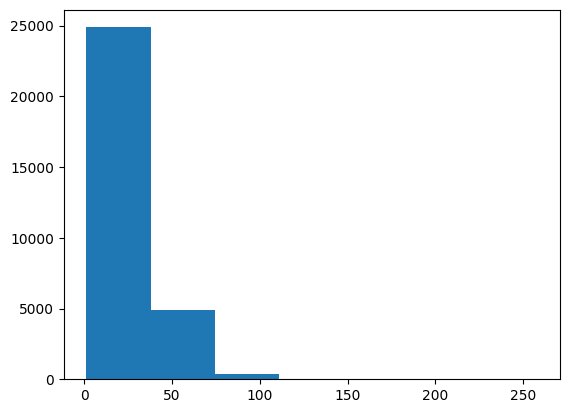

In [28]:
# Lets check the distribution of the sentence length
import matplotlib.pyplot as plt
sentence_lengths=[len(i.split()) for i in train_sentences]
plt.hist(sentence_lengths,bins=7)

In [29]:
# How long of a sentence covers 95% of the lengths?
import numpy as np
output_sen_len=int(np.percentile(sentence_lengths,95))
output_sen_len

55

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.



In [30]:
import tensorflow as tf

max_length=55
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=68000,
                                                  output_sequence_length=max_length)


let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.



In [31]:
text_vectorizer.adapt(train_sentences)

In [32]:
# Testing our text vectorizer
import random
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
pre-specified secondary outcomes were changes in body weight , homa-ir , metabolic syndrome ( ms ) measures , leptin , and adiponectin .        

Vectorized version:


<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[1313,  157,   76,    9,  154,    5,  256,  201, 2831,  728,  417,
         964,  214, 6614,    3, 5218,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [33]:
# how many words are there in the vocabolary
rct_20k_vocab=text_vectorizer.get_vocabulary()
len(rct_20k_vocab)

25008

In [34]:
# Get the configuration of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 25008}

In [35]:
len(rct_20k_vocab)

25008

In [36]:
embeddings=tf.keras.layers.Embedding(input_dim=len(rct_20k_vocab), # length of vocabolary
                                     output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                                     mask_zero=True, # Use masking to handle variable sequences lengths
                                     name="embedding")


In [37]:
# Testing our text vectorizer
import random
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
print(text_vectorizer([random_sentence]))

# testing our embedding
print("########## After embeddings #########")
after_embeddings=embeddings(text_vectorizer([random_sentence]))
after_embeddings,after_embeddings.shape

Original text:
the mean calcium intake was @ @ mg/d and serum @ ( oh ) d was @ @ nmol/l at baseline .        

Vectorized version:
tf.Tensor(
[[   2   53 1541  351   10 1298    3  244 1605  180   10 1949   16   50
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)
########## After embeddings #########


(<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[ 0.02545626, -0.03685591,  0.04159356, ..., -0.04811586,
          -0.01353885,  0.00658343],
         [ 0.04927615, -0.00489407,  0.01184184, ..., -0.00254636,
           0.04840914,  0.02432002],
         [-0.00360794, -0.02582135, -0.00436939, ..., -0.03600902,
          -0.0076965 ,  0.02379792],
         ...,
         [ 0.01722045,  0.00787631,  0.01054745, ..., -0.03359162,
          -0.01852623, -0.00437423],
         [ 0.01722045,  0.00787631,  0.01054745, ..., -0.03359162,
          -0.01852623, -0.00437423],
         [ 0.01722045,  0.00787631,  0.01054745, ..., -0.03359162,
          -0.01852623, -0.00437423]]], dtype=float32)>,
 TensorShape([1, 55, 128]))

To create a batched PrefetchDataset we can use the methods betch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow Tensowflow to determine the optimal amount of compute to use to prepare datasets

In [38]:
# Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
validation_dataset=tf.data.Dataset.from_tensor_slices((validation_sentences,validation_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the tensor slices and turn them in to prefetch Batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Model 1: Conv1D with token embeddings

Input(text)-> Tokenize-> Embeddings -> Layers -> Output (label Probalility)

In [40]:
# Build a model with Functional API
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
x=layers.Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1_dense")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary(
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 55, 128)        │     3,201,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,242,373 (12.37 MB)

 Trainable params: 3,242,373 (12.37 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Fit the model
model_1_history=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)), # Only fit 10% of the batches for the faster training time
                            epochs=5,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(validation_dataset))
                            )

Epoch 1/5
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3153 - loss: 1.5003

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.3165 - loss: 1.4992 - val_accuracy: 0.5094 - val_loss: 1.2997
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5353 - loss: 1.1589 - val_accuracy: 0.6435 - val_loss: 0.8880
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6644 - loss: 0.8486 - val_accuracy: 0.6886 - val_loss: 0.7749
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7003 - loss: 0.7619 - val_accuracy: 0.7189 - val_loss: 0.7371
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7189 - loss: 0.7376 - val_accuracy: 0.7263 - val_loss: 0.7152


In [42]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7238 - loss: 0.7186


[0.7152349948883057, 0.7262983322143555]

In [43]:
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


array([[0.71651983, 0.6168426 , 0.38270244, 0.5510569 , 0.12180202],
       [0.29386476, 0.20816576, 0.923359  , 0.42544508, 0.18328084],
       [0.0403158 , 0.04556642, 0.99615204, 0.08564682, 0.8196124 ],
       ...,
       [0.09888558, 0.52676284, 0.5073256 , 0.05406569, 0.94992846],
       [0.22792289, 0.4635591 , 0.6801538 , 0.1105135 , 0.8803234 ],
       [0.13544461, 0.7096599 , 0.19257501, 0.14114399, 0.7740615 ]],
      dtype=float32)

In [44]:
model_1_results=calculate_results(y_true=validation_labels,y_pred=tf.argmax(model_1_pred_probs,axis=1))
model_1_results

{'accuracy': 72.62983242077318,
 'precision': 0.7218496249355031,
 'recall': 0.7262983242077319,
 'f1': 0.7117471327481524}

# Model 2: Transfer Learning
The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)


There is lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

In [45]:
# download the pretrained USE
import tensorflow_hub as hub
tf_hub_embeddings=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="Universal_sentence_encoder"

                                )


In [46]:
# lets test this pretrained embedding on a random sentence
tf_hub_embeddings([random_sentence])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.00373557, -0.02115405, -0.00529531, -0.03322442, -0.02667352,
         0.05342428,  0.00158975,  0.03706087,  0.00766055,  0.05812238,
         0.01618551,  0.03709045, -0.04515425,  0.05695583, -0.08853193,
        -0.03040999, -0.03325393,  0.08251486,  0.0075095 ,  0.00857904,
        -0.07971729, -0.05969068, -0.03452222, -0.02334191, -0.05710603,
        -0.04895816,  0.06105087, -0.01615   ,  0.01061311,  0.03219769,
        -0.07630964,  0.0915279 ,  0.05765484,  0.02245149, -0.05602723,
         0.02785195, -0.04784749, -0.00453227,  0.02803134,  0.00842119,
         0.05788557,  0.04824861, -0.01584133,  0.07886814,  0.01423173,
         0.02447024, -0.01721098,  0.04671942,  0.04072132, -0.00059816,
         0.02058038, -0.02663067, -0.00467929, -0.03435716,  0.03270212,
         0.03192814,  0.00227278,  0.02997621,  0.07735478, -0.06173814,
         0.00198361, -0.01823302,  0.03894188, -0.00468802, -0.05675602,
 

In [47]:
# length of embedding
len(tf_hub_embeddings([random_sentence])[0])

512

In [48]:
# inputs = layers.Input(shape=[], dtype=tf.string)
# pretrained_embedding = tf_hub_embeddings(inputs) # tokenize text and create embedding
# x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# # Note: you could add more layers here if you wanted to
# outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
# model_2 = tf.keras.Model(inputs=inputs,
#                         outputs=outputs)

# # Compile the model
# model_2.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [49]:
# Building and fitting an NLP feature extraction model from TF Hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Wrap USE inside a custom Keras Layer
class USEEmbedding(tf.keras.layers.Layer):
    def __init__(self, trainable=False, **kwargs):
        super(USEEmbedding, self).__init__(trainable=trainable, **kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Keras Input (1D: batch of strings)
input_text = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")

# Embed using our wrapped USE Layer
embedding = USEEmbedding()(input_text)

# Add classification layers
x = layers.Dense(128, activation="relu")(embedding)
output = layers.Dense(num_classes, activation="sigmoid")(x)

# Build model
model_2 = Model(inputs=input_text, outputs=output)
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Show model summary
model_2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding (USEEmbedding)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=5,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset))
            )

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4021 - loss: 0.5708 - val_accuracy: 0.5645 - val_loss: 0.3832
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5785 - loss: 0.3645 - val_accuracy: 0.6370 - val_loss: 0.3240
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6447 - loss: 0.3184 - val_accuracy: 0.6669 - val_loss: 0.3055
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6714 - loss: 0.3015 - val_accuracy: 0.6725 - val_loss: 0.2961
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6567 - loss: 0.3048 - val_accuracy: 0.6918 - val_loss: 0.2883


In [51]:
# Evaluate
model_2_preds=model_2.predict(valid_dataset)
model_2_preds

942/942 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


array([[0.4342206 , 0.16233046, 0.17977983, 0.25821105, 0.02311125],
       [0.15749921, 0.09452142, 0.4939919 , 0.21139203, 0.01152465],
       [0.00746541, 0.01450854, 0.9379996 , 0.00637806, 0.11353775],
       ...,
       [0.00343746, 0.02979523, 0.03468885, 0.00094049, 0.93072546],
       [0.0284382 , 0.07623503, 0.1172111 , 0.01428585, 0.7865331 ],
       [0.01549106, 0.3150947 , 0.3638515 , 0.02622725, 0.1262401 ]],
      dtype=float32)

In [52]:
model_2_results=calculate_results(validation_labels,tf.argmax(model_2_preds,axis=1))
model_2_results

{'accuracy': 67.96747967479675,
 'precision': 0.6741576759428011,
 'recall': 0.6796747967479675,
 'f1': 0.6680531689215379}

# Model 3: Conv1D with character embeddings
The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens. Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

In [53]:
# Make function to split senntences into characters
def split_sentences(text):
  return " ".join(list(text))

In [54]:
# Testing functioon
split_sentences(random_sentence)

't h e   m e a n   c a l c i u m   i n t a k e   w a s   @   @   m g / d   a n d   s e r u m   @   (   o h   )   d   w a s   @   @   n m o l / l   a t   b a s e l i n e   .'

In [55]:
# Lets  create character level dataset by splitting our dataset into characters
train_chars=[split_sentences(s) for s in train_sentences]
val_chars=[split_sentences(s) for s in validation_sentences]
test_chars=[split_sentences(s) for s in test_sentences]
test_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [56]:
# lets check the average character length
char_length=[len(s) for s in train_sentences]
mean_chars=np.mean(char_length)
mean_chars

np.float64(149.19111611280286)

(array([1.8576e+04, 1.0579e+04, 9.2800e+02, 1.0600e+02, 1.6000e+01,
        5.0000e+00, 2.0000e+00]),
 array([   2.        ,  157.14285714,  312.28571429,  467.42857143,
         622.57142857,  777.71428571,  932.85714286, 1088.        ]),
 <BarContainer object of 7 artists>)

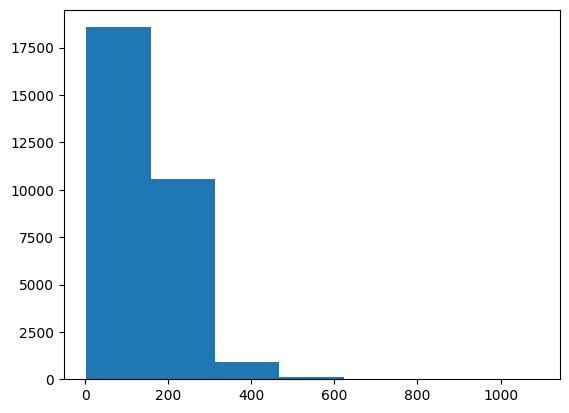

In [57]:
plt.hist(char_length,bins=7
         )

In [58]:
# Lets find the 95% percentile of our character length
output_char_length=int(np.percentile(char_length,95))
output_char_length

290

we'll set the max_tokens ( the total number of different character in our sentences) to 28, in other words, 26 letters of the alphabet + space +OOV (Out of vocabolary or unknown) tokens.


In [59]:
# get all keyboard character for character level embeddings
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [60]:
# create  char level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet)+2 # this means number of characters in alphabet + space + OOV token
char_vectorizer=tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_char_length,
                                  standardize="lower_and_strip_punctuation",
                                  name="char_vectorizer")
# adapt char vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [61]:
# lets check the character vocabolary characterstics
char_vocab= char_vectorizer.get_vocabulary()
print(f"Number of character in vocabolary {len(char_vocab)}")
print(f" 5 most common characters { char_vocab[:5]}")
print(f" 5 least common characters { char_vocab[:-5]}")

Number of character in vocabolary 28
 5 most common characters ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
 5 least common characters ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i'), np.str_('a'), np.str_('n'), np.str_('o'), np.str_('r'), np.str_('s'), np.str_('d'), np.str_('c'), np.str_('l'), np.str_('h'), np.str_('p'), np.str_('m'), np.str_('u'), np.str_('f'), np.str_('g'), np.str_('y'), np.str_('w'), np.str_('v'), np.str_('b')]


In [62]:
# Lets test out char vectorizer
random_chars=random.choice(train_chars)
print(f"Random sentence : {random_chars}")
print(f"vectorized sentence : {char_vectorizer([random_chars])}")
print(f"length: {len(char_vectorizer([random_chars])[0])}")

Random sentence : c l i n i c a l t r i a l s . g o v   :   n c t @   .
vectorized sentence : [[11 12  4  6  4 11  5 12  3  8  4  5 12  9 18  7 21  6 11  3  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
length: 

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for [Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251), the output dimension of the character embedding (output_dim) will be 25.

In [63]:
# create a character embedding layer
print(random_chars)
char_embedding=layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                output_dim=25,
                                mask_zero=False,
                                name="char_embedding")

char_embedding_output=char_embedding(char_vectorizer([random_chars]))
print(char_embedding_output)

c l i n i c a l t r i a l s . g o v   :   n c t @   .
tf.Tensor(
[[[-0.00728596  0.02159294  0.02164084 ... -0.00260261  0.03746629
   -0.02815504]
  [-0.01772862  0.04762429 -0.01831704 ... -0.02284648 -0.02408074
   -0.02810076]
  [-0.00147054  0.00200035 -0.01273507 ...  0.00719695 -0.04901464
    0.00550497]
  ...
  [ 0.02885893 -0.0366493   0.0150923  ...  0.01884839 -0.01659147
    0.00870001]
  [ 0.02885893 -0.0366493   0.0150923  ...  0.01884839 -0.01659147
    0.00870001]
  [ 0.02885893 -0.0366493   0.0150923  ...  0.01884839 -0.01659147
    0.00870001]]], shape=(1, 290, 25), dtype=float32)


Lets make our model

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [64]:
inputs=layers.Input(shape=(1,),dtype="string")
char_vectors=char_vectorizer(inputs)
embedding=char_embedding(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same", activation="relu")(embedding)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )

In [65]:
model_3.summary()

Model: "model_3_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embedding (Embedding)      │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

Before fitting our model, lets create a char-level batched PrefetchedDataset

In [66]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,validation_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Just line our token-level sequence model, to save time with our experiments, we'll fit our model in 10% of batches

In [68]:
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=5,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))


Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3095 - loss: 1.5405 - val_accuracy: 0.4578 - val_loss: 1.4114
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4232 - loss: 1.4023 - val_accuracy: 0.4545 - val_loss: 1.3110
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4651 - loss: 1.2970 - val_accuracy: 0.5156 - val_loss: 1.1732
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5201 - loss: 1.1819 - val_accuracy: 0.5406 - val_loss: 1.0899
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5350 - loss: 1.1276 - val_accuracy: 0.5718 - val_loss: 1.0492


In [69]:
# evaluate on whole validation dataset
model_3.evaluate(val_char_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5594 - loss: 1.0776


[1.0799273252487183, 0.5580886006355286]

In [70]:
# Make predictions
model_3_pred=model_3.predict(val_char_dataset)
model_3_pred

942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


array([[0.3046122 , 0.19122885, 0.18838374, 0.20194831, 0.11382685],
       [0.14258374, 0.28708333, 0.23931105, 0.14769006, 0.18333186],
       [0.01807877, 0.02535191, 0.4671553 , 0.01169424, 0.47771984],
       ...,
       [0.01022409, 0.0331662 , 0.11333869, 0.01064458, 0.8326264 ],
       [0.03354989, 0.06762888, 0.3336622 , 0.01700521, 0.5481539 ],
       [0.1243641 , 0.29970136, 0.3218982 , 0.11500224, 0.13903406]],
      dtype=float32)

In [71]:
# convert predictions to classes
model_3_pred_classes=tf.argmax(model_3_pred,axis=1)
model_3_pred_classes

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 1, 4, ..., 4, 4, 2])>

In [72]:
model_3_results=calculate_results(validation_labels,model_3_pred_classes)
model_3_results

{'accuracy': 55.808860129417624,
 'precision': 0.5748982281172661,
 'recall': 0.5580886012941763,
 'f1': 0.5198768492464168}

# Model 4: combining pretrained token embeddings and char embeddings (hybrid embedding)

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Combine (using layers.Concatenate) the outputs of 1 and 2
Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [73]:
# # 1. Setup token input model
# token_inputs=layers.Input(shape=[],dtype="string",name="token_input")
# # token_vectors=text_vectorizer(token_inputs)
# # token_embedding=embeddings(token_vectors)
# token_embedding=tf_hub_embeddings(token_inputs)
# token_outputs=layers.Dense(128,activation="relu")(token_embedding)
# token_model=tf.keras.Model(token_inputs,token_outputs)

# #2. setup char input model
# char_inputs=layers.Input(shape=(1,),dtype="string",name="char_input")
# char_vectors=char_vectorizer(char_inputs)
# char_embedding=char_embedding(char_vectors)
# char_bi_lstm=layers.Bidirectional(layers.LSTM(64))(char_embedding)
# char_model=tf.keras.Model(char_inputs,char_bi_lstm)

# # 3. concatenate token and char model 1 and 2
# token_char_concat=layers.Concatenate(name="concatenated_model")([token_model.output, char_model.output])

# # 4. create output layers. addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
# combined_dropout=layers.Dropout(0.5)(token_char_concat)
# combined_debse=layers.Dense(200, activation="relu")(combined_dropout)
# final_dropout=layers.Dropout(0.5)(combined_dense)
# output_layer=layers.Dense(5,activation="softmax")(final_fropout)

# #5. construct model with char and token inputs
# model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
#                        outputs=output_layer,
#                        name="model_4_hybrid")


In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text  # Required for USE

# Step 1: Wrap the USE model in a Keras-compatible layer
class USEWrapper(layers.Layer):
    def __init__(self, **kwargs):
        super(USEWrapper, self).__init__(**kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Step 2: Token-level input model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embedding = USEWrapper(name="use_layer")(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embedded = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedded)
char_model = keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Step 4: Concatenate token and char outputs
token_char_concat = layers.Concatenate(name="concatenated")(
    [token_model.output, char_model.output]
)

# Step 5: Output layers
x = layers.Dropout(0.5)(token_char_concat)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(5, activation="softmax")(x)  # Adjust number of classes

# Step 6: Full model
model_4 = keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_hybrid"
)

# Compile model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Optional: Print model summary
model_4.summary()


Model: "model_4_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer           │ (None, 512)       │          0 │ token_input[0][0] │
│ (USEWrapper)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 290, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ use_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50)        │     10,200 │ char_embedding[1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated        │ (None, 178)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178)       │          0 │ concatenated[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │     35,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │      1,005 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,419 (446.95 KB)

 Trainable params: 114,419 (446.95 KB)

 Non-trainable params: 0 (0.00 B)